In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
from matplotlib.patches import Rectangle
from matplotlib import cm

In [5]:
if torch.cuda.is_available():
    print("CUDA (GPU support) is available in PyTorch!")
else:
    print("CUDA (GPU support) is not available in PyTorch.")

CUDA (GPU support) is available in PyTorch!


In [7]:
torch.manual_seed(42)
np.random.seed(42)

In [8]:
class Puasson2DPINN(nn.Module):
    def __init__(self, layers, optimizer):
        super(Puasson2DPINN, self).__init__()
        self.hidden_layers = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        for layer in self.hidden_layers:
            nn.init.xavier_normal_(layer.weight, gain=nn.init.calculate_gain('tanh'))
        self.optimizer = optimizer

    def forward(self, x1_x2):
        for layer in self.hidden_layers[:-1]:
            x1_x2 = torch.tanh(layer(x1_x2))
        x1_x2 = self.hidden_layers[-1](x1_x2)  # No activation after last layer
        return x1_x2

    def compute_gradients(self, x1_x2):
        x1_x2.requires_grad_(True)
        
        u = self.forward(x1_x2)
        grads = torch.autograd.grad(u, x1_x2, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x1, u_x2 = grads[:, 0], grads[:, 1]

        u_x1_x1 = torch.autograd.grad(u_x1, x1_x2, grad_outputs=torch.ones_like(u_x1), create_graph=True)[0][:, 0]
        u_x2_x2 = torch.autograd.grad(u_x2, x1_x2, grad_outputs=torch.ones_like(u_x2), create_graph=True)[0][:, 1]

        return u, u_x1, u_x2, u_x1_x1, u_x2_x2
    
    def dirichlet_condition(
            self, x1_x2_bc_up_1, x1_x2_bc_up_2, x1_x2_bc_down_1, x1_x2_bc_down_2,
            u_bc_up_1, u_bc_up_2, u_bc_down_1, u_bc_down_2
        ):
        x1_x2_bc_up_1, x1_x2_bc_up_2 = x1_x2_bc_up_1.float(), x1_x2_bc_up_2.float()
        x1_x2_bc_down_1, x1_x2_bc_down_2 = x1_x2_bc_down_1.float(), x1_x2_bc_down_2.float()
        
        u_up_1, _, _, _, _ = self.compute_gradients(x1_x2_bc_up_1)
        u_up_2, _, _, _, _ = self.compute_gradients(x1_x2_bc_up_2)
        u_down_1, _, _, _, _ = self.compute_gradients(x1_x2_bc_down_1)
        u_down_2, _, _, _, _ = self.compute_gradients(x1_x2_bc_down_2)
        
        return torch.mean((u_up_1 - u_bc_up_1)**2) + \
               torch.mean((u_up_2 - u_bc_up_2)**2) + \
               torch.mean((u_down_1 - u_bc_down_1)**2) + \
               torch.mean((u_down_2 - u_bc_down_2)**2)

    def neuman_condition(self, x1_x2_bc_left_right):
        x1_x2_bc_left_right = x1_x2_bc_left_right.float()
        _, u_x1, _,  _, _ = self.compute_gradients(x1_x2_bc_left_right)
        return torch.mean(u_x1**2)  # Assuming no change in the problem statement

    def loss_fn(
            self, x1_x2_train, u_x1_x1, u_x2_x2, x1_x2_bc_left_right, x1_x2_bc_up_1, x1_x2_bc_up_2,
            x1_x2_bc_down_1, x1_x2_bc_down_2, u_bc_up_1, u_bc_up_2, u_bc_down_1, u_bc_down_2
        ):
        x1_x2_train = x1_x2_train.float()
        puasson_eq = u_x1_x1 + u_x2_x2 - self.f(x1_x2_train)
        bc_dirichlet = self.dirichlet_condition(
            x1_x2_bc_up_1, x1_x2_bc_up_2, x1_x2_bc_down_1, x1_x2_bc_down_2,
            u_bc_up_1, u_bc_up_2, u_bc_down_1, u_bc_down_2
        )
        bc_neuman = self.neuman_condition(x1_x2_bc_left_right)

        return torch.mean(puasson_eq**2) + 5 * (bc_dirichlet + bc_neuman)

    def train_loop(
            self, loss_threshold, x1_x2_train, x1_x2_bc_left_right, x1_x2_bc_up_1, x1_x2_bc_up_2, x1_x2_bc_down_1,
            x1_x2_bc_down_2, u_bc_up_1, u_bc_up_2, u_bc_down_1, u_bc_down_2
        ):
        loss_array = []
        start_time = time.time()

        loss = torch.tensor(1.0)
        epoch = 0
        while loss.item() > loss_threshold:
            self.optimizer.zero_grad()
            u_fdm, u_x1, u_x2, u_x1_x1, u_x2_x2 = self.compute_gradients(x1_x2_train)
            loss = self.loss_fn(
                    x1_x2_train, u_x1_x1, u_x2_x2, x1_x2_bc_left_right, x1_x2_bc_up_1, x1_x2_bc_up_2, x1_x2_bc_down_1,
                    x1_x2_bc_down_2, u_bc_up_1, u_bc_up_2, u_bc_down_1, u_bc_down_2
                )
            loss.backward()
            self.optimizer.step()

            loss_array.append(loss.item())
            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')
            epoch += 1

        print(f"Training took {time.time() - start_time} seconds")
        print(f"Last epoch: {epoch}, loss: {loss.item()}")

        plt.plot(loss_array)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid()
        plt.title('Mean loss')
        plt.savefig('2D_PINN_half_dirichlet_Laplace_training.png')
        plt.show(block=False)

    def f(self, x1_x2):
        # Assuming x1_x2 is a PyTorch tensor
        x1, x2 = x1_x2[:, 0], x1_x2[:, 1]
        return torch.ones_like(x1)  # Assuming f(x1, x2) = 1 as per the provided definition

Epoch 0, Loss: 60.556915283203125
Epoch 100, Loss: 2.8182790279388428
Epoch 200, Loss: 1.9165446758270264
Epoch 300, Loss: 1.4272534847259521
Epoch 400, Loss: 1.1130954027175903
Epoch 500, Loss: 0.95919269323349
Epoch 600, Loss: 0.8627698421478271
Epoch 700, Loss: 0.8137639164924622
Epoch 800, Loss: 0.7905986309051514
Epoch 900, Loss: 0.784352719783783
Epoch 1000, Loss: 0.7613537311553955
Epoch 1100, Loss: 0.747848629951477
Epoch 1200, Loss: 0.7326540350914001
Epoch 1300, Loss: 0.7166820764541626
Epoch 1400, Loss: 0.7018181085586548
Epoch 1500, Loss: 0.6717727780342102
Epoch 1600, Loss: 0.6562488675117493
Epoch 1700, Loss: 0.6330466270446777
Epoch 1800, Loss: 0.6109094619750977
Epoch 1900, Loss: 0.5907805562019348
Epoch 2000, Loss: 0.616900622844696
Epoch 2100, Loss: 0.5554876327514648
Epoch 2200, Loss: 0.5332096815109253
Epoch 2300, Loss: 0.51901775598526
Epoch 2400, Loss: 0.6245298385620117
Training took 23.05035638809204 seconds
Last epoch: 2448, loss: 0.4990980625152588


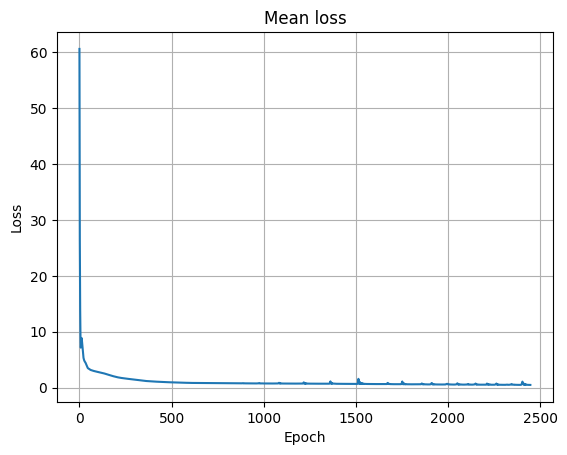

In [11]:
# Assuming the Puasson2DPINN class has been defined according to previous instructions

# Define hyperparameters and boundary conditions
N_of_train_points = 11
N_of_test_points = 201
L_x1, R_x1, L_x2, R_x2 = 0.0, 1.0, 0.0, 1.0
Dirichlet_up_left, Dirichlet_up_right = 0, 1
Dirichlet_down_left, Dirichlet_down_right = 1, 0
loss_threshold = 0.5
layers = [2, 20, 20, 20, 1]  # Adjusted to include input and output layers
learning_rate = 0.005

# Generate training points
x1_train = torch.linspace(L_x1, R_x1, N_of_train_points).unsqueeze(-1)
x2_train = torch.linspace(L_x2, R_x2, N_of_train_points).unsqueeze(-1)
x1_mesh, x2_mesh = torch.meshgrid(x1_train.squeeze(), x2_train.squeeze(), indexing='ij')
x1_x2_train = torch.hstack((x1_mesh.flatten().unsqueeze(-1), x2_mesh.flatten().unsqueeze(-1)))

# Boundary condition for left and right (Neuman condition)
# bc - boundary condition (left and right) neuman
#         __________________________
#         ||                       ||
# [-1, 0] || x2                    || [1, 0] 
#         ||          x1           ||
#         ||_______________________||
# ∂u/∂n = -∂u/∂x1                      ∂u/∂n = ∂u/∂x1
x1_bc_left_right = torch.cat((L_x1 * torch.ones_like(x2_train), R_x1 * torch.ones_like(x2_train)))
x2_bc_left_right = torch.cat((x2_train, x2_train))
x1_x2_bc_left_right = torch.hstack((x1_bc_left_right, x2_bc_left_right))

# Boundary condition for up and down (Dirichlet condition)
# bc - boundary condition (up and down) dirichlet
#          [0, 1]  ∂u/∂n = ∂u/∂x2
#  =======================
# |                       |
# | x2                    |
# |          x1           |
# |=======================|
#          [0, -1]  ∂u/∂n = -∂u/∂x2
split_index = len(x1_train) // 2
x2_bc_up = R_x2 * torch.ones_like(x1_train)
x2_bc_down = L_x2 * torch.ones_like(x1_train)
x1_x2_bc_up = torch.hstack((x1_train, x2_bc_up))
x1_x2_bc_down = torch.hstack((x1_train, x2_bc_down))

# Dirichlet boundary values
u_bc_up = torch.cat((Dirichlet_up_left * torch.ones(split_index, 1), Dirichlet_up_right * torch.ones(len(x1_train) - split_index, 1)))
u_bc_down = torch.cat((Dirichlet_down_left * torch.ones(split_index, 1), Dirichlet_down_right * torch.ones(len(x1_train) - split_index, 1)))

# Initialize model
model_2D = Puasson2DPINN(layers, None)
optimizer = optim.Adam(model_2D.parameters(), lr=learning_rate)
model_2D.optimizer = optimizer  # Assuming the optimizer is set as an attribute of the model

# Run training loop
model_2D.train_loop(
    loss_threshold, x1_x2_train, x1_x2_bc_left_right, x1_x2_bc_up, x1_x2_bc_up, x1_x2_bc_down,
    x1_x2_bc_down, u_bc_up, u_bc_up, u_bc_down, u_bc_down
)

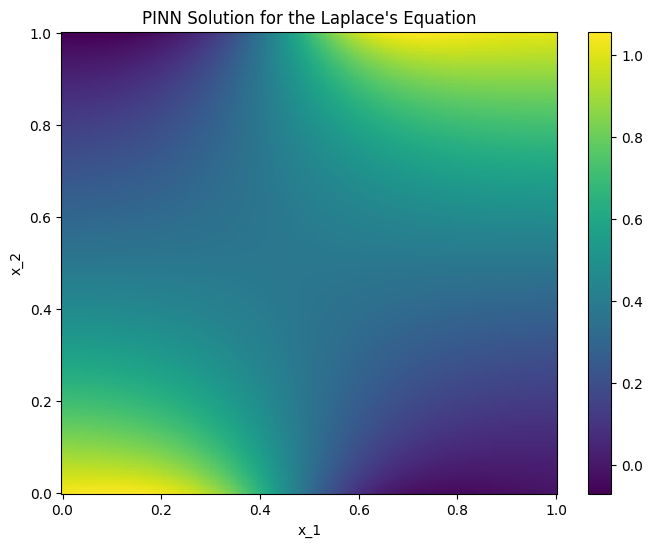

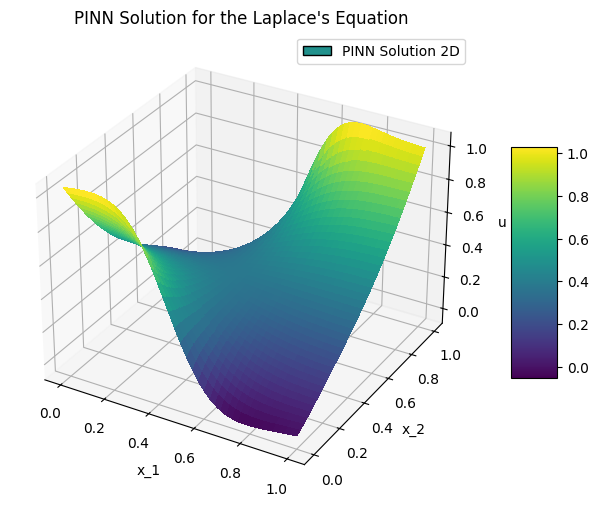

In [12]:
# Generate test points
x_test = torch.linspace(L_x1, R_x1, N_of_test_points).unsqueeze(-1)
x2_test = torch.linspace(L_x2, R_x2, N_of_test_points).unsqueeze(-1)
x1_mesh, x2_mesh = torch.meshgrid(x_test.squeeze(), x2_test.squeeze(), indexing='ij')
x1x2_test = torch.hstack((x1_mesh.flatten().unsqueeze(-1), x2_mesh.flatten().unsqueeze(-1)))

# Get the model prediction. Assume model_2D's forward method can handle tensor inputs
u_pred = model_2D(x1x2_test.float()).detach().numpy().reshape(x_test.shape[0], x2_test.shape[0])

# Visualization using pcolor
plt.figure(figsize=(8, 6))
plt.pcolor(x1_mesh.numpy(), x2_mesh.numpy(), u_pred, cmap='viridis')
plt.colorbar()
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.title('PINN Solution for the Laplace\'s Equation')
plt.savefig('PINN_solution_half_dirichlet_Laplace_3D_heatmap_pytorch.png')
plt.show()

# Visualization using 3D plot_surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x1_mesh.numpy(), x2_mesh.numpy(), u_pred, cmap='viridis', linewidth=0, antialiased=False)

ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_zlabel('u')
ax.set_title('PINN Solution for the Laplace\'s Equation')

color_for_legend = cm.viridis(0.5)  # Get the color from the colormap
proxy = Rectangle((0, 0), 1, 1, fc=color_for_legend, edgecolor="k")
ax.legend([proxy], ['PINN Solution 2D'])

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig('PINN_solution_half_dirichlet_Laplace_3D_pytorch.png')
plt.show()

In [ ]:
print("Solving useing FEM")
from fenics import *
import matplotlib.pyplot as plt
import numpy as np

# Create mesh and define function space
nx, ny = N_of_train_points, N_of_train_points  # number of nodes in the x and y directions
mesh = UnitSquareMesh(101, 101)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary conditions
def boundary_upper_left(x, on_boundary):
    return on_boundary and near(x[1], R_x1) and x[0] <= 0.5

def boundary_upper_right(x, on_boundary):
    return on_boundary and near(x[1], R_x1) and x[0] > 0.5

def boundary_lower_left(x, on_boundary):
    return on_boundary and near(x[1], L_x1) and x[0] <= 0.5

def boundary_lower_right(x, on_boundary):
    return on_boundary and near(x[1], L_x1) and x[0] > 0.5

bc_upper_left = DirichletBC(V, Constant(Dirichlet_up_left), boundary_upper_left)
bc_upper_right = DirichletBC(V, Constant(Dirichlet_up_right), boundary_upper_right)
bc_lower_left = DirichletBC(V, Constant(Dirichlet_down_left), boundary_lower_left)
bc_lower_right = DirichletBC(V, Constant(Dirichlet_down_right), boundary_lower_right)

bcs = [bc_upper_left, bc_upper_right, bc_lower_left, bc_lower_right]

# Define problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(1)  # source term
a = -dot(grad(u), grad(v))*dx
L = f*v*dx

# Compute solution
u = Function(V)
solve(a == L, u, bcs)

# Plot solution using matplotlib
c = plot(u)
plt.colorbar(c)
plt.title("FEM solution of Laplace\'s equation")
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('fenics_solution_half_dirichlet_Laplace_heatmap.png')
plt.show()

# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(L_x1, R_x1, N_of_test_points)
y = np.linspace(L_x2, R_x2, N_of_test_points)
X, Y = np.meshgrid(x, y)
points = np.vstack((X.ravel(), Y.ravel())).T

# Initialize an array to store the solution
u_fenics = np.zeros_like(points[:, 0])

# Evaluate the FEniCS solution at each point
for i, point in enumerate(points):
    u_fenics[i] = u(point)

# Reshape the solution to a 2D grid for plotting or comparison
u_fenics_grid = u_fenics.reshape((len(x), len(y)))

surf = ax.plot_surface(X, Y, u_fenics_grid, cmap='viridis', edgecolor='k')
plt.colorbar(surf)
plt.title("3D plot of the solution")
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('u')
plt.savefig('fenics_solution_half_dirichlet_Laplace_3D.png')
plt.show()

print("Mean Squared Error (PINN and FEM):", np.mean((u_fenics_grid - u_pred)**2))

relative_error = calculate_max_relative_error(u_fenics_grid, u_pred)
print(f"Relative error (PINN and FEM): {relative_error:.2f}%")